# Visualization of Conv Nets

In [1]:
import os
import re
import random
import io
import urllib.request
import functools as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

from keras import models
from keras.models import load_model
from keras.preprocessing import image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras import backend as K

from IPython.display import display, HTML

Using TensorFlow backend.


In [2]:
model = load_model('var/model/cats_and_dogs_small_2.h5')

In [3]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [4]:
model.output[0]

<tf.Tensor 'strided_slice:0' shape=(1,) dtype=float32>

In [5]:
def get_image(image_url):
    with urllib.request.urlopen(image_url) as fh:
        image_data = fh.read()
    return PIL.Image.open(io.BytesIO(image_data))

def image_preprocess(img):
    return img.convert('RGB').resize((150, 150))

def image_to_model_array(img):
    img_arr = image.img_to_array(img) / 255
    img_arr = img_arr.reshape((1,) + img_arr.shape)
    return img_arr

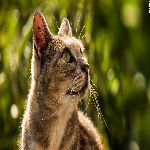

In [6]:
img = get_image("https://i1.wp.com/media.boingboing.net/wp-content/uploads/2019/02/trump.jpeg?fit=640%2C420&ssl=1")
#img = get_image("https://www.bing.com/th/id/OIP.VaQHItXswINeZZm7DsX3jAHaE6?w=299&h=195&c=7&o=5&dpr=1.5&pid=1.7")
img = get_image("https://cdn.cnn.com/cnnnext/dam/assets/180830100926-02-new-zealand-cat-stock-super-tease.jpg")
img = image_preprocess(img)
img

In [7]:
model.predict_proba(image_to_model_array(img))

array([[0.30569428]], dtype=float32)

In [8]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(image_to_model_array(img))

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


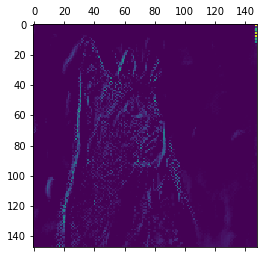

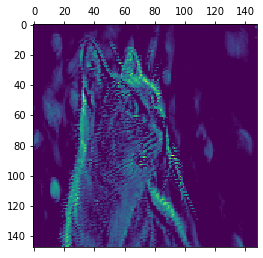

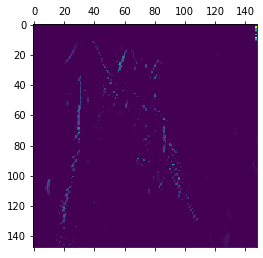

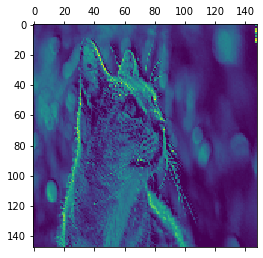

In [9]:
for i in range(0, 4):
    plt.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

c:\users\bryan\source\rook_keras_learn\venv\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


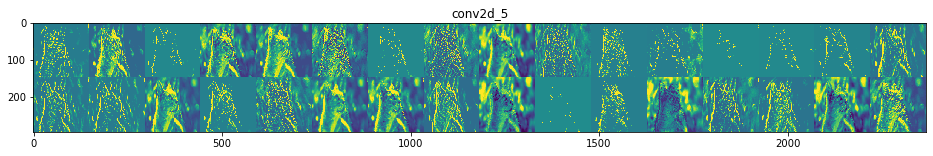

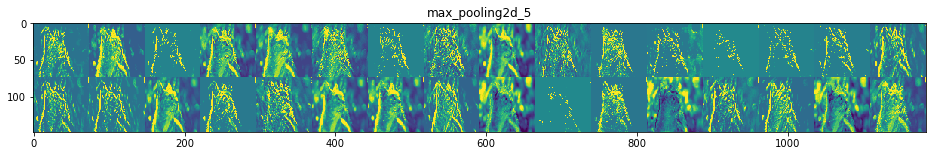

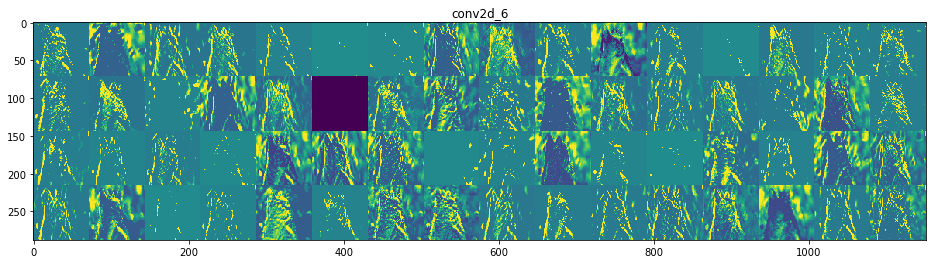

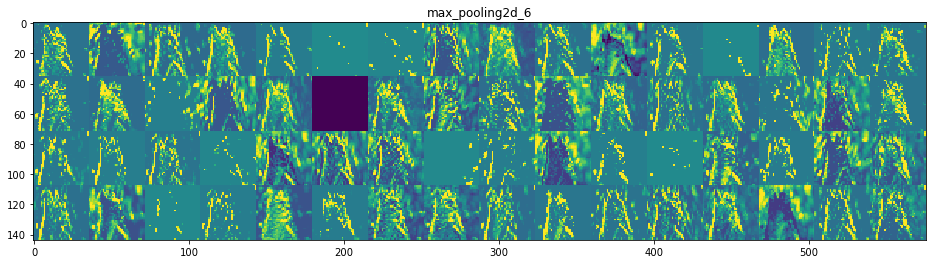

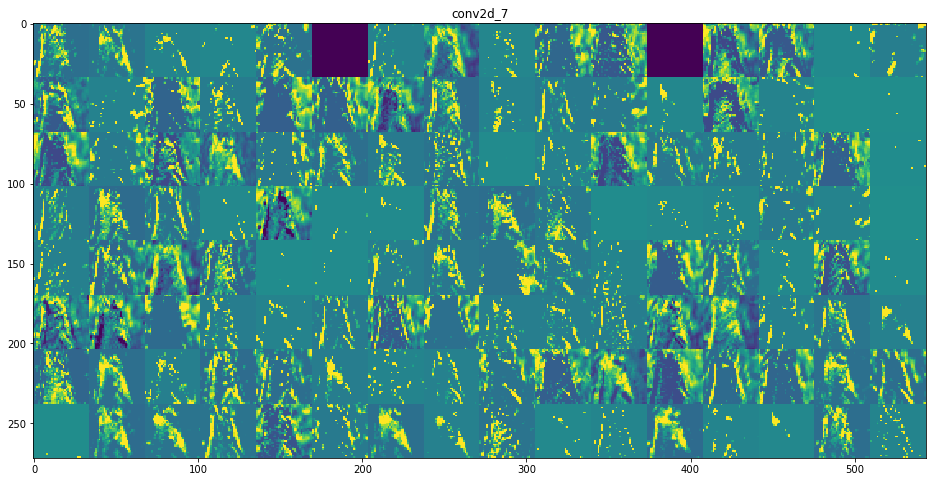

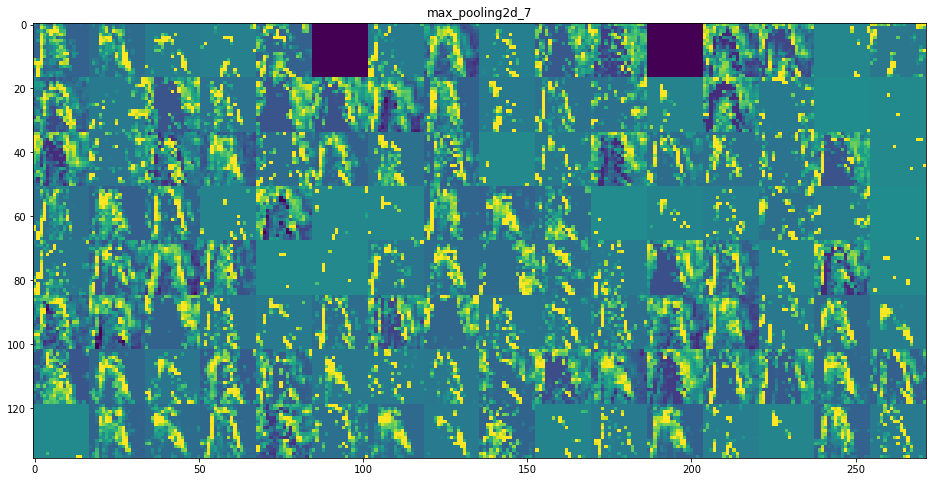

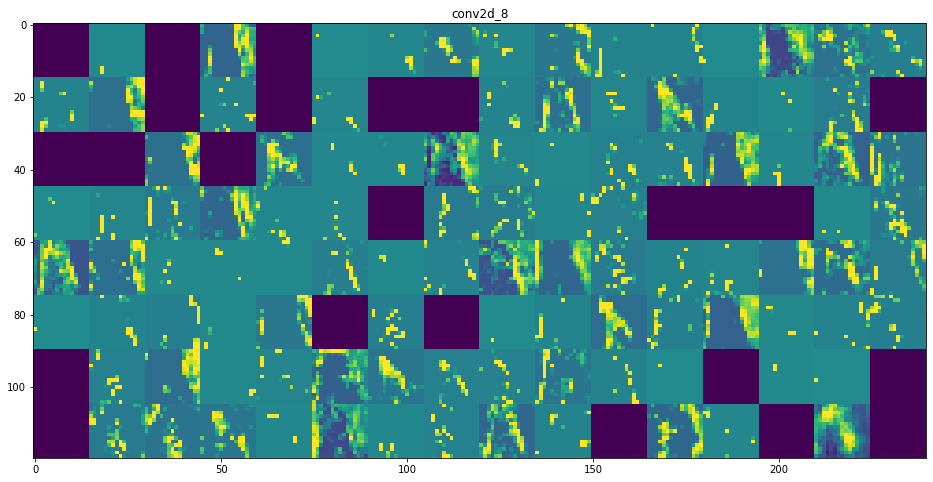

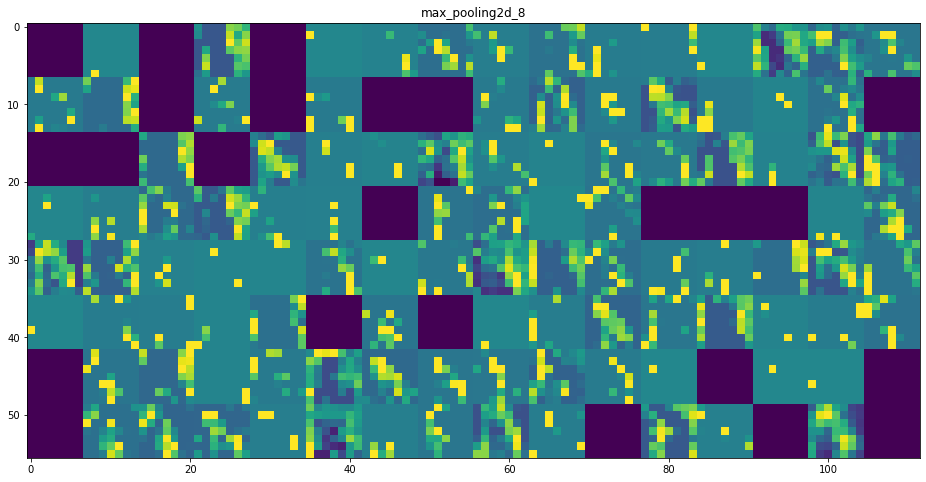

In [10]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    images_per_row = 16
    
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
            :, :,
            col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
            row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Visualize Activation Heatmap

In [11]:
in_model = VGG16(weights='imagenet')

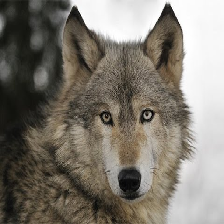

Predicted: [('n02114367', 'timber_wolf', 0.59626156), ('n02114548', 'white_wolf', 0.24681462), ('n02114712', 'red_wolf', 0.06253677)]


NameError: name 'cv2' is not defined

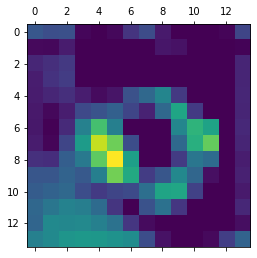

In [12]:
img_url = "https://i.ytimg.com/vi/LKeBIMgACxU/hqdefault.jpg"
img = get_image(img_url)
img = img.convert('RGB').resize((224, 224))
display(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = in_model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

tgt_output = in_model.output[:, np.argmax(preds[0])]
last_conv_layer = in_model.get_layer('block5_conv3')

grads = K.gradients(tgt_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function(
    [in_model.input],
    [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

with urllib.request.urlopen(img_url) as fh:
    image_data = fh.read()
    with open("var/test_image.jpg", "wb") as out_fh:
        out_fh.write(image_data)

img = cv2.imread("var/test_image.jpg")

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img
cv2.imwrite('var/test_image_w_heatmap.jpg', superimposed_img)

display(HTML("<img src='var/test_image_w_heatmap.jpg'>"))